# But First

In [1]:
import requests
import bs4
import re
from bs4 import BeautifulSoup
import math
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 12]

# Retrieve Job Description Data from Indeed.com

In [2]:
base_url = ''

# Declare job titles to search on indeed.com
titles = [{
    'title': 'data scientist',
    'urltitle': 'data+scientist'
}, {
    'title': 'quantitative analyst',
    'urltitle': 'quantitative+analyst'
}, {
    'title': 'statistician',
    'urltitle': 'statistician'
}, {
    'title': 'data analyst',
    'urltitle': 'data+analyst'
}, {
    'title': 'research scientist',
    'urltitle': 'research+scientist'
}, {
    'title': 'machine learning engineer',
    'urltitle': 'machine+learning+engineer'
}, {
    'title': 'data engineer',
    'urltitle': 'data+engineer'
}]

In [4]:
# Function to retireve Job Description from provided job url
def storedescription(term, url):
    try:
        r = requests.get('https://www.indeed.com'+url)
        soup = BeautifulSoup(r.text, 'html.parser')
        description = soup.find('div', id="jobDescriptionText").get_text()
        jobdescription.append(description)
    except Exception as e:
        print(f'description error: {e}')
        jobdescription.append("")

In [ ]:
# Lists to hold retrieved values
jobtitles = []
urls = []
jobclass = []
jobdescription = []

# search by job title
for term in titles:
    startlen = len(urls)
    try:
        r = requests.get('https://www.indeed.com/jobs?q={}&sort=date&limit=50'.format(term['urltitle']))
        #r = requests.get('https://www.indeed.com/jobs?q={}&l=New+York%2C+NY&sort=date&limit=50'.format(term['urltitle']))
        soup = BeautifulSoup(r.text, 'html.parser')
        count_str = soup.find('div', id="searchCountPages").get_text()
        max_results = int(count_str.split()[3].replace(',', ''))

        # calculate how many pages we need to query
        max_results = math.ceil(max_results/50)
        time.sleep(1)
    except Exception as e:
        print(f'title error: {e}') 

    print('Querying {} pages for {}'.format(max_results, term['title']))
    for x in range(0, max_results):

        try:
            split = '&start='+format(x*50)
            html = requests.get('https://www.indeed.com/jobs?q={}&sort=date&limit=50+{}'.format(term['urltitle'], split))
            #html = requests.get('https://www.indeed.com/jobs?q={}&l=New+York%2C+NY&sort=date&limit=50+{}'.format(term['urltitle'], split))
            soup = BeautifulSoup(html.text, 'html.parser')
            for link in soup.findAll('a'):
                try:
                    # only retireve urls from matching titles
                    if term['title'].lower() in link.attrs['title'].lower():
                        jobtitles.append(link.attrs['title'])
                        urls.append(link.attrs['href'])
                        jobclass.append(term['title'])
                        storedescription(term['title'], link.attrs['href'])
                        
                except Exception as e:
                    print(f'{x} attribute link error: {e}') 
            time.sleep(1)
        except Exception as e:
            print(f'link error: {e}')

    print('.. found {} results for {}'.format(len(urls)-startlen, term['title']))

In [6]:
print(len(jobtitles))
print(len(urls))
print(len(jobclass))
print(len(jobdescription))

3013
3013
3013
3013


In [7]:
df = pd.DataFrame({'title': jobtitles, 'jobclass': jobclass, 'url': urls, 'jobdescription': jobdescription})
#df = pd.DataFrame({'jobdescription': jobdescription})

In [8]:
df.to_csv("../exported_data/indeed_data_raw.csv")

# Process Job Decsription Data

In [2]:
raw_df = pd.read_csv("../exported_data/indeed_data_raw.csv")
del raw_df["Unnamed: 0"]

jobtitles_raw = raw_df.title.astype(str).values.tolist()
jobclass_raw = raw_df.jobclass.astype(str).values.tolist()
urls_raw = raw_df.url.astype(str).values.tolist()
jobdescription_raw = raw_df.jobdescription.astype(str).values.tolist()

print("Jobtitles: " + str(len(jobtitles_raw)))
print("URLS: " + str(len(urls_raw)))
print("Job Classes: " + str(len(jobclass_raw)))
print("Job Descriptions: " + str(len(jobdescription_raw)))

Jobtitles: 3013
URLS: 3013
Job Classes: 3013
Job Descriptions: 3013


In [3]:
raw_df.dtypes

title             object
jobclass          object
url               object
jobdescription    object
dtype: object

In [4]:
raw_df['title'].value_counts()

Data Scientist                                                                                          795
Economy Hotel Data Analyst/Operations Support                                                           241
Data Analyst - contractor                                                                               241
Data Analyst-Regional Systems Improvement Spec                                                          241
Data Analyst III(populantion Health, SQL, Pharmacy)                                                     196
                                                                                                       ... 
Federal - Data Analyst - SI                                                                               1
1879 - Principal / Senior Biostatistician - Vaccines Clinical Trials Required (Remote, US or Canada)      1
MATHEMATICAL STATISTICIAN                                                                                 1
STATISTICIAN                

In [5]:
raw_df['jobclass'].value_counts()

data scientist               1364
data analyst                 1100
research scientist            234
statistician                  167
machine learning engineer     106
quantitative analyst           32
data engineer                  10
Name: jobclass, dtype: int64

In [6]:
def preprocess(line):
    line = line.replace('\n', ' ') # newlines
    line = line.replace('(', ' ')
    line = line.replace(')', ' ')
    line = line.replace('[', ' ') 
    line = line.replace(']', ' ')
    line = line.replace('.', ' ')
    line = line.replace(',', ' ')
    line = line.replace('&', ' ')
    line = line.replace(' - ', ' ')
    line = line.replace(':', ' ') # We dont need summaries, just give me tokens
    line= line.replace('\t', ' ') #tabs
    
    # converts line endings in a way that stops the accidental camelcasing
    # but leaves terms like SAP intact
    line= re.sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1 ', line)
    
    # regex to address the issue of text continuing directly after a period
    # instead of a space
    line = re.sub(r'\.(?! )', '. ', re.sub(r' +', ' ', line))
    return line

In [7]:
raw_df["jobdescription"][10]

"Please make sure to read the job posting in its entirety as it reflects both the University roles and responsibilities, followed by the specific description.\nDepartment\n2012223 Medicine-Genetic Medicine\nAbout the Unit\nJob Family\nResearch\nResponsible for all aspects of research projects and research facilities. Plans and conducts clinical and non-clinical research; facilitates and monitors daily activities of clinical trials or research projects. Directs engineering and technical support activities to develop and maintain tools and computational methods needed to gather and analyze data.\nCareer Track and Job Level\nData Science\nConducts data investigation, including data wrangling, cleaning, sampling, management, exploratory analysis, regression and classification, prediction, and data communication. Implements foundational concepts of data computation, such as data structure, algorithms, parallel computing, simulation, and analysis. Utilizes knowledge in game theory, statistic

In [8]:
# jobdescription = df.jobdescription
description = [preprocess(d) for d in jobdescription_raw]

len(description)

3013

In [9]:
description[10]

"Please make sure to read the job posting in its entirety as it reflects both the University roles and responsibilities followed by the specific description Department 2012223 Medicine-Genetic Medicine About the Unit Job Family Research Responsible for all aspects of research projects and research facilities Plans and conducts clinical and non-clinical research; facilitates and monitors daily activities of clinical trials or research projects Directs engineering and technical support activities to develop and maintain tools and computational methods needed to gather and analyze data Career Track and Job Level Data Science Conducts data investigation including data wrangling cleaning sampling management exploratory analysis regression and classification prediction and data communication Implements foundational concepts of data computation such as data structure algorithms parallel computing simulation and analysis Utilizes knowledge in game theory statistical quality control exponential

In [10]:
processed_df = pd.DataFrame({'title': jobtitles_raw, 'jobclass': jobclass_raw, 'url': urls_raw, 'jobdescription': description})
#processed_df = pd.DataFrame({'jobdescription': description})

In [11]:
processed_df.to_csv("../exported_data/indeed_data_processed.csv")

# Find Words Counts from Processed Descriptions

In [12]:
postprocessed_df = pd.read_csv("../exported_data/indeed_data_processed.csv")
del postprocessed_df["Unnamed: 0"]

jobtitles_post = postprocessed_df.title.astype(str).values.tolist()
jobclass_post = postprocessed_df.jobclass.astype(str).values.tolist()
urls_post = postprocessed_df.url.astype(str).values.tolist()
jobdescription_post = postprocessed_df.jobdescription.astype(str).values.tolist()

print("Jobtitles: " + str(len(jobtitles_post)))
print("URLS: " + str(len(urls_post)))
print("Job Classes: " + str(len(jobclass_post)))
print("Job Descriptions: " + str(len(jobdescription_post)))

Jobtitles: 3013
URLS: 3013
Job Classes: 3013
Job Descriptions: 3013


C:\Users\budchris\anaconda3\envs\PythonAdv\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row

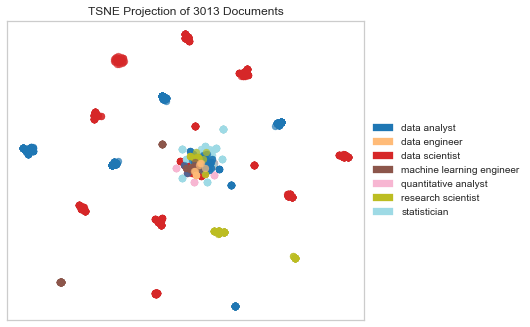

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from yellowbrick.text import TSNEVisualizer

tfidf = TfidfVectorizer(stop_words='english')

X = tfidf.fit_transform(jobdescription_post)
y = jobclass_post

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer(decompose_by=75, decompose='svd', colormap='tab20')
tsne.fit(X, y)
tsne.show()

In [14]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\budchris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# Initializing Dictionary
d = {}
postprocessed_df["jobdescription_split"] = postprocessed_df["jobdescription"].astype(str).str.lower().str.split()

p_description = postprocessed_df["jobdescription_split"].apply(lambda x: [item for item in x if item not in stop])
p_description

0       [preventable, illnesses, still, kill, tens, th...
1       [data, scientist, pricing, analytics, team, sh...
2       [data, scientist, data, scientist, experience,...
3       [medidata, leading, digital, transformation, l...
4       [position, summary, data, scientist, participa...
                              ...                        
3008    [data, engineer, data, engineer, experience, p...
3009    [8+, years, experience, data, engineering, 4+,...
3010    [bachelor's, degree, computer, science, engine...
3011    [role, important, us, cca, need, enterprise, d...
3012    [department, information, technology, services...
Name: jobdescription_split, Length: 3013, dtype: object

In [16]:
# counting number of times each word comes up in list of words (in dictionary)
for word_list in p_description:
    #word_list = descr.split()
    for word in word_list: 
        d[word] = d.get(word, 0) + 1

In [17]:
word_freq = []
for key, value in d.items():
    word_freq.append((value, key))

In [18]:
word_freq.sort(reverse=True) 
print(word_freq)

[(27502, 'data'), (15528, 'experience'), (9949, 'work'), (7631, 'analysis'), (7298, 'team'), (6902, 'business'), (5779, 'analytics'), (5598, 'required'), (4904, 'knowledge'), (4712, 'years'), (4710, 'ability'), (4529, 'including'), (4354, 'science'), (4216, 'skills'), (4216, 'position'), (3972, 'research'), (3826, 'management'), (3709, 'scientist'), (3621, 'information'), (3404, '·'), (3353, 'job'), (3337, 'statistical'), (3313, 'process'), (3307, 'tools'), (3292, 'new'), (3287, 'degree'), (3254, 'client'), (3082, 'systems'), (3070, 'improvement'), (3025, 'learning'), (2992, 'use'), (2955, 'help'), (2925, 'strong'), (2912, 'office'), (2911, 'requirements'), (2831, 'techniques'), (2809, 'python'), (2705, 'leadership'), (2663, 'regional'), (2514, 'using'), (2493, 'machine'), (2463, 'must'), (2425, 'role'), (2402, 'system'), (2385, 'design'), (2363, 'employment'), (2352, 'aclu'), (2350, 'provide'), (2348, 'company'), (2335, 'apply'), (2315, 'related'), (2310, 'develop'), (2192, 'solutions

# TF-IDF

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(jobdescription_raw)

In [20]:
print(vectorizer.get_feature_names())
print(X.shape)

['00', '000', '000mw', '0023r', '0034', '0051', '00pm', '01', '02', '02109', '02111', '02506', '03', '04', '05', '05375', '06', '0660', '0681', '07', '07677', '07960', '08', '09', '0abab791f984f247be6581e96addee0e', '0hhzyallbn', '10', '100', '100k', '101', '103', '103698', '104', '104k', '10546', '107', '107807', '10795', '10859293', '10870152', '10870153', '10872452', '10883477', '11', '110', '111', '11103', '112', '114', '11649', '11753', '118', '118084', '1183', '118k', '12', '120', '1200', '120k', '12205', '123', '125', '1251', '12564', '12721', '129', '12th', '13', '130', '138', '138k', '14', '140', '1400', '140146', '14155', '143', '145', '15', '150', '1500', '150k', '1529', '1530', '1550', '157', '16', '160', '1600', '1601', '165', '17', '170', '1700', '1725', '176055br', '1784', '179', '18', '1840', '185', '187', '19', '190', '19146', '1915', '1930', '1938', '1939', '1941', '1950', '1954', '1959', '1960', '1975', '1979', '1980', '1983', '1986', '1987', '1991', '1997', '1998', 

In [21]:
print(X[0,])

  (0, 9136)	0.022062665525295237
  (0, 10212)	0.022203386416519706
  (0, 7639)	0.029180669869896897
  (0, 3035)	0.01815605422752958
  (0, 4833)	0.025799905904593388
  (0, 4318)	0.02688964688506058
  (0, 6795)	0.026793966931917827
  (0, 8698)	0.026986288461880694
  (0, 6798)	0.022250754768238325
  (0, 6376)	0.02180990708866513
  (0, 8696)	0.02512047437030218
  (0, 8055)	0.022322247706895403
  (0, 2060)	0.022358194499987365
  (0, 7810)	0.022227041424645266
  (0, 7983)	0.026475597342917483
  (0, 10449)	0.0238344693453764
  (0, 2736)	0.023198149229928095
  (0, 3461)	0.017489534256197876
  (0, 5847)	0.03256862188854928
  (0, 3456)	0.018273083127879914
  (0, 3591)	0.018304532889206068
  (0, 2432)	0.060607851863251704
  (0, 9528)	0.02994220929476691
  (0, 8516)	0.03299448141311927
  (0, 118)	0.07608381405187004
  :	:
  (0, 4884)	0.09830475075847844
  (0, 9610)	0.16406554054884614
  (0, 5164)	0.029528564618035276
  (0, 2664)	0.07041817556235307
  (0, 834)	0.2501756087719411
  (0, 7570)	0.06020

In [22]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

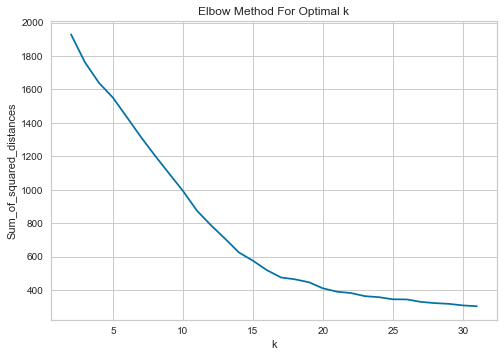

In [23]:
Sum_of_squared_distances = []
K = range(2,32)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [24]:
true_k = 23
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X)
labels=model.labels_
indeed_cl=pd.DataFrame(list(zip(jobclass_raw,labels)),columns=['title','cluster'])
print(indeed_cl.sort_values(by=['cluster']))



                          title  cluster
2000               data analyst        0
2400               data analyst        0
2110               data analyst        0
1960               data analyst        0
2600               data analyst        0
...                         ...      ...
2979  machine learning engineer       22
2977  machine learning engineer       22
2976  machine learning engineer       22
2933  machine learning engineer       22
2978  machine learning engineer       22

[3013 rows x 2 columns]


In [25]:
indeed_cl.groupby(['cluster'])['cluster'].count()

cluster
0     241
1     197
2     241
3     147
4     165
5      66
6     241
7     147
8     147
9     106
10    147
11    147
12     72
13     45
14     54
15    147
16     21
17    147
18     25
19      2
20     24
21    462
22     22
Name: cluster, dtype: int64

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\budchris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\budchris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Cluster: 0
Titles:
 data analyst


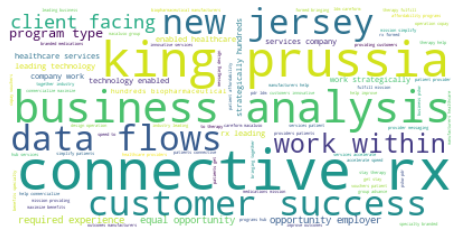

Cluster: 1
Titles:
 data analyst


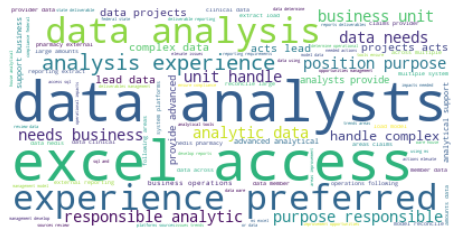

Cluster: 2
Titles:
 data analyst


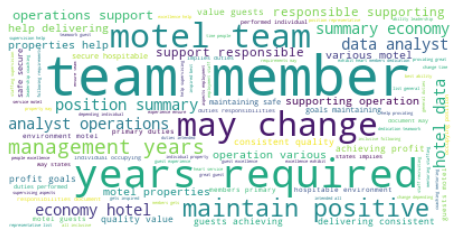

Cluster: 3
Titles:
 data scientist


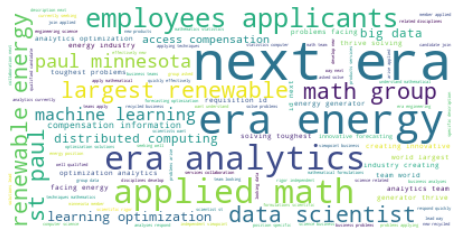

Cluster: 4
Titles:
 research scientist


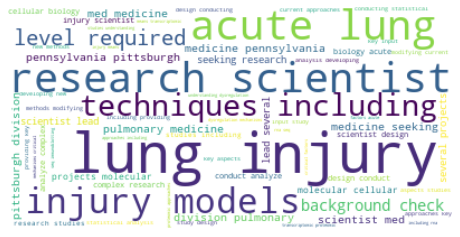

Cluster: 5
Titles:
 machine learning engineer


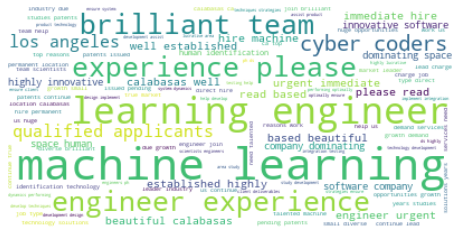

Cluster: 6
Titles:
 data analyst


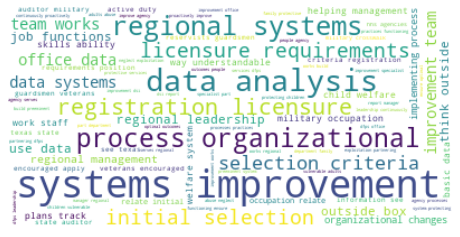

Cluster: 7
Titles:
 data scientist


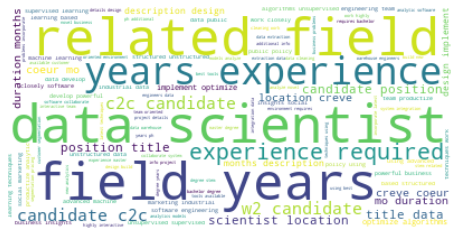

Cluster: 8
Titles:
 data scientist


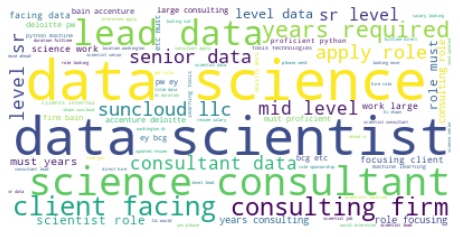

Cluster: 9
Titles:
 data scientist


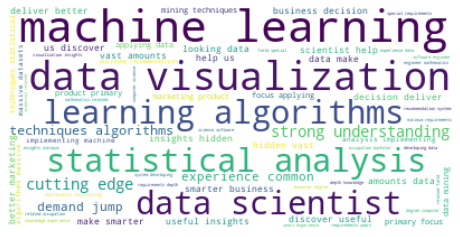

Cluster: 10
Titles:
 data scientist


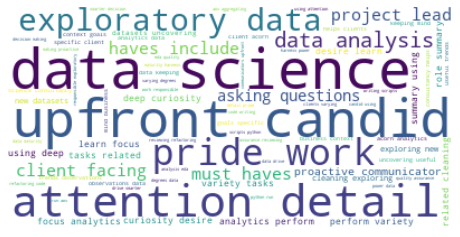

Cluster: 11
Titles:
 data scientist


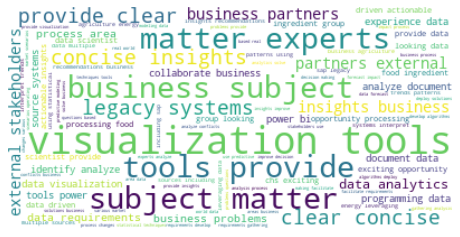

Cluster: 12
Titles:
 data scientist


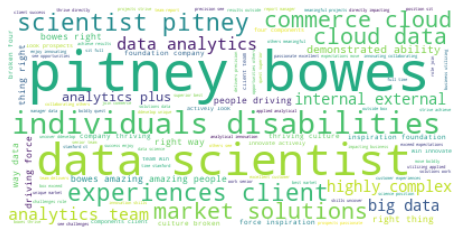

Cluster: 13
Titles:
 research scientist


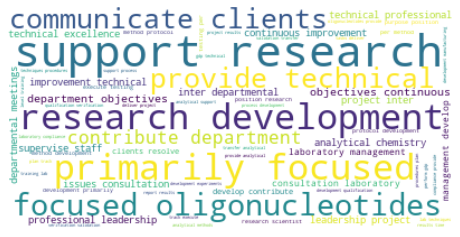

Cluster: 14
Titles:
 data analyst


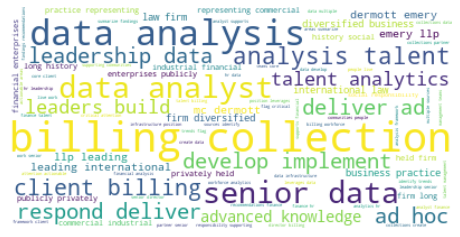

Cluster: 15
Titles:
 data scientist


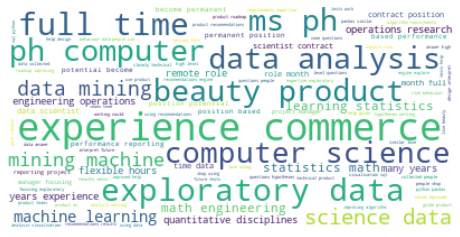

Cluster: 16
Titles:
 data analyst


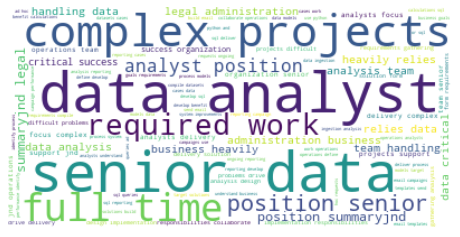

Cluster: 17
Titles:
 data scientist


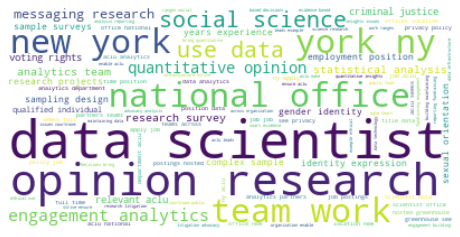

Cluster: 18
Titles:
 data scientist


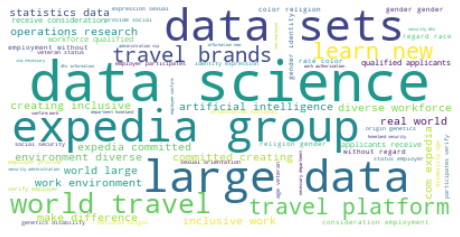

Cluster: 19
Titles:
 statistician
 data analyst


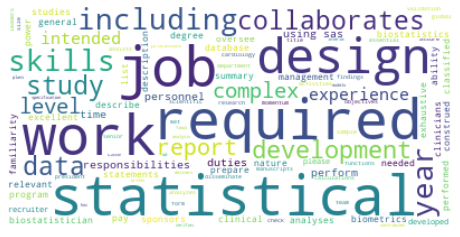

Cluster: 20
Titles:
 data scientist


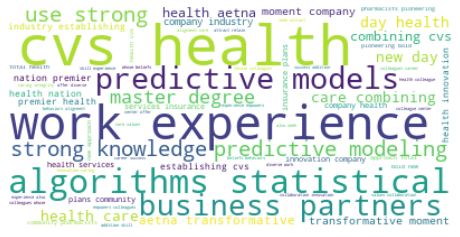

Cluster: 21
Titles:
            data scientist
      quantitative analyst
              statistician
              data analyst
        research scientist
 machine learning engineer
             data engineer


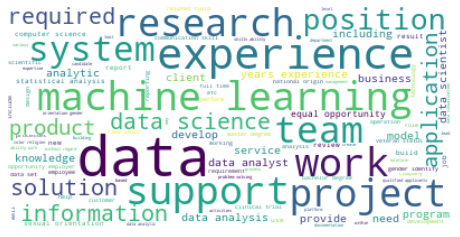

Cluster: 22
Titles:
 machine learning engineer


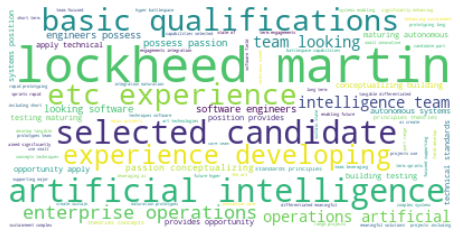

In [26]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize 

stop_words = set(stopwords.words('english'))  

result={'cluster':labels,'jobdescription':jobdescription_post}
result=pd.DataFrame(result)
for k in range(0,true_k):
# for k in range(0,1):
    s=result[result.cluster==k]
    
    text=s['jobdescription'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    
    word_tokens = word_tokenize(text) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 

    text=' '.join([str(elem) for elem in filtered_sentence])

    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    print('Cluster: {}'.format(k))
    print('Titles:')
    titles=indeed_cl[indeed_cl.cluster==k]['title']
    titles=titles.drop_duplicates()
    print(titles.to_string(index=False))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()